# Goal:
1. dist_center
2. ring
3. classification (likelihood of being another country)[pending]
4. Carbon Flux
5. TOD relationship (current year and previous year)
6. POI relationship

In [1]:
import os
import gspread
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import h3
import gc
import math
from tqdm import tqdm
from haversine import haversine, Unit

# Get Hex detail by 
1. Relationship to city center
2. By TOD differences

In [2]:
GC_URL = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
RAW_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_boundary_osm"
CURATE_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_longitudinal_year"
EXPORT_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_hex"
if not os.path.exists(EXPORT_FOLDER):
    os.makedirs(EXPORT_FOLDER)
    
serviceaccount = "../../google_drive_personal.json"
gs = gspread.service_account(filename=serviceaccount)
def read_url(url, SHEET_NAME):
    SHEET_ID = url.split("/")[5]
    spreadsheet = gs.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet

In [3]:

city_meta, other_worksheet = read_url(GC_URL, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
city_meta["country_clean"] = np.where(city_meta["Country"].isin(["USA", "United States"]), 
                                      "United States of America",
                                      city_meta["Country"]
                                     )
city_meta['cityabbr'] = city_meta['City'].str.lower().str.replace(" ", "")

In [7]:
# For all hexagons generated from the segmentation model, calculate their distance from the city center, and assign development ring to them
# load all hexagon first
files = os.listdir(CURATE_FOLDER)
# city = "Modesto"


In [11]:
def get_dist_center(city):
    cityabbr = city.lower().replace(" ", "")
    temp = pd.read_parquet(os.path.join(CURATE_FOLDER, cityabbr+".parquet"))
    temp_hex = temp[['hex_id','res']].drop_duplicates()
    # city_center = city_meta[['City','center_lat','center_lng']]
    city_center = city_meta[city_meta['City']==city][['center_lat','center_lng']].reset_index(drop = True)
    temp_hex = temp[['hex_id','res']].drop_duplicates()
    # get the centroid coordinates of the hexagons
    temp_hex['centroid'] = temp_hex['hex_id'].apply(lambda x: h3.h3_to_geo(x))
    temp_hex['lat'] = temp_hex['centroid'].apply(lambda x: x[0])
    temp_hex['lng'] = temp_hex['centroid'].apply(lambda x: x[1])
    temp_hex.drop(columns = ['centroid'], inplace = True)

    temp_hex['dist_ctr_m'] = temp_hex.apply(lambda x: 
        haversine((x['lat'], x['lng']), (city_center['center_lat'].values[0], 
                city_center['center_lng'].values[0]), unit = Unit.METERS), axis = 1)
    return temp_hex

In [12]:
all_hex = []
for city in tqdm(city_meta['City'].unique()):
    try:
        temp = get_dist_center(city)
        temp['city'] = city
        all_hex.append(temp)
    except:
        print(city)
        continue
all_hex = pd.concat(all_hex).reset_index(drop = True)
all_hex.head()

100%|██████████| 127/127 [01:56<00:00,  1.09it/s]


,hex_id,res,lat,lng,dist_ctr_m,city
0,88c2e30201fffff,8,-34.545954,-58.456019,9126.663212,Buenos Aires
1,88c2e30203fffff,8,-34.540138,-58.461514,9931.670411,Buenos Aires
2,88c2e30205fffff,8,-34.546039,-58.447277,8530.320164,Buenos Aires
3,88c2e30207fffff,8,-34.540222,-58.452774,9342.942345,Buenos Aires
4,88c2e30209fffff,8,-34.551685,-58.459264,8960.518066,Buenos Aires


In [14]:
all_hex.to_parquet(os.path.join(EXPORT_FOLDER, "c_hex_ctr_dist.parquet"), index = False)

# Load the POIs  (pending)

In [15]:
EXPORTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_pois"
if not os.path.exists(EXPORTFOLDER):
    os.makedirs(EXPORTFOLDER)
# city_bound_folder = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_boundary_osm"
# bound_files = os.listdir(city_bound_folder)
poi_files = os.listdir(EXPORTFOLDER)
poi_files

['mexicocity.geojson',
 'stockholm.geojson',
 'capetown.geojson',
 'miami.geojson',
 'parbhani.geojson',
 'gaborone.geojson',
 'kigali.geojson',
 'jequie.geojson',
 'guadalajara.geojson',
 'detroit.geojson',
 'kanpur.geojson',
 'malegaon.geojson',
 'guatemalacity.geojson',
 'berezniki.geojson',
 'hyderabad.geojson',
 'bangalore.geojson',
 'curitiba.geojson',
 'antwerp.geojson',
 'kaunas.geojson',
 'tyumen.geojson',
 'nairobi.geojson',
 'lagos.geojson',
 'ribeiraopreto.geojson',
 'cebucity.geojson',
 'milan.geojson',
 'saintpetersburg.geojson',
 'lemans.geojson',
 'toronto.geojson',
 'palermo.geojson',
 'reynosa.geojson',
 'london.geojson',
 'hongkong.geojson',
 'victoria.geojson',
 'culiacan.geojson',
 'philadelphia.geojson',
 'wellington.geojson',
 'istanbul.geojson',
 'athens.geojson',
 'taipei.geojson',
 'johannesburg.geojson',
 'vijayawada.geojson',
 'houston.geojson',
 'jaipur.geojson',
 'brussels.geojson',
 'toledo.geojson',
 'yamaguchi.geojson',
 'bogotá.geojson',
 'modesto.geoj

In [35]:
# load all files and concatenate them to get a unique list of all amenity types
amenity_df = []
all_stations = []
station_key = ['station','stop','railway','train']
for file in tqdm(poi_files):
    temp = gpd.read_file(os.path.join(EXPORTFOLDER, file))
    amenity_df.append(temp[['amenity']].drop_duplicates())
    station_df = temp[temp['amenity'].str.contains('|'.join(station_key), case = False)].reset_index(drop = True)
    station_df['cityabbr'] = file.split(".")[0]
    all_stations.append(station_df)
amenity_df = pd.concat(amenity_df).drop_duplicates().reset_index(drop = True)
all_stations = pd.concat(all_stations).reset_index(drop = True)

100%|██████████| 127/127 [09:47<00:00,  4.63s/it] 


In [36]:
category = """Agriculture, Forestry, Fishing and Hunting
Mining, Quarrying, and Oil and Gas Extraction
Utilities
Construction
Manufacturing
Wholesale Trade
Retail Trade
Transportation and Warehousing
Information
Finance and Insurance
Real Estate and Rental and Leasing
Professional, Scientific, and Technical Services
Management of Companies and Enterprises
Administrative and Support and Waste Management and Remediation Services
Educational Services
Health Care and Social Assistance
Arts, Entertainment, and Recreation
Accommodation and Food Services
Other Services (except Public Administration)
Public Administration
""".replace("\n",";\n")
print(category)

Agriculture, Forestry, Fishing and Hunting;
Mining, Quarrying, and Oil and Gas Extraction;
Utilities;
Construction;
Manufacturing;
Wholesale Trade;
Retail Trade;
Transportation and Warehousing;
Information;
Finance and Insurance;
Real Estate and Rental and Leasing;
Professional, Scientific, and Technical Services;
Management of Companies and Enterprises;
Administrative and Support and Waste Management and Remediation Services;
Educational Services;
Health Care and Social Assistance;
Arts, Entertainment, and Recreation;
Accommodation and Food Services;
Other Services (except Public Administration);
Public Administration;



In [27]:
amenity_df.to_csv(os.path.join(EXPORT_FOLDER, "c_amenity_list.csv"), index = False)

In [31]:
# create a sheet in the same google url to store the amenity list
# create a new sheet to store the amenity list

SHEET_ID = GC_URL.split("/")[5]
spreadsheet = gs.open_by_key(SHEET_ID)
amenity_sheet = spreadsheet.add_worksheet(title = "amenity_list", rows = 100, cols = 1)
amenity_sheet.update([amenity_df.columns.values.tolist()] + amenity_df.values.tolist())


{'spreadsheetId': '1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw',
 'updatedRange': 'amenity_list!A1:A1656',
 'updatedRows': 1656,
 'updatedColumns': 1,
 'updatedCells': 1656}

## B. construct current railway TOD and bus TOD
-- These are downloaded from 2024.Oct

In [7]:
TRANSIT_EXPORT = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_pois/transit"
TRANSFORMED_EXPORT = "/lustre1/g/geog_pyloo/05_timemachine/_transformed/t_pois/transit"

# process the 2017 files
SOURCE_FOLDER = "/scr/u/yuanzf/02_timemachine/02_osm/data/t_public_transport/{year}"
city_bound_folder = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_boundary_osm"

if not os.path.exists(TRANSFORMED_EXPORT):
    os.makedirs(TRANSFORMED_EXPORT)

In [14]:
# resummarize the transit data for 2024
t_files = os.listdir(TRANSIT_EXPORT)

all_stations= []
for f in t_files:
    if not f.endswith(".geojson"):
        continue
    try:
        temp = gpd.read_file(os.path.join(TRANSIT_EXPORT, f))
        temp['cityabbr'] = f.split(".")[0]
        all_stations.append(temp)
    except:
        print(f)
        continue
    
all_stations = pd.concat(all_stations).reset_index(drop = True)

copenhagen.geojson


In [16]:
# get only point or polygon geometry
def clean_stations(all_stations):
    """Seperate the bus, train, and other stations"""
    all_stations = all_stations[all_stations['geometry'].apply(lambda x: x.geom_type in ['Point','Polygon'])].reset_index(drop = True)
    # get the centroid coordinates of the stations and stops if it is a polygon, otherwise use the point coordinates
    all_stations['lat'] = all_stations['geometry'].apply(lambda x: x.centroid.y if x.geom_type == 'Polygon' else x.y)
    all_stations['lng'] = all_stations['geometry'].apply(lambda x: x.centroid.x if x.geom_type == 'Polygon' else x.x)
    # get area if this is a polygon
    all_stations['area'] = all_stations['geometry'].apply(lambda x: x.area if x.geom_type == 'Polygon' else None)
    bus_station = all_stations[(all_stations['amenity'].str.contains("bus", case = False))|\
        all_stations['bus'].isin(['yes','yea', 'designated','minibus','mini_bus','小2', 'urban', 
                                  'bus_station','yes @ (Th 16:00-18:30)'])|\
            all_stations['public_transport'].isin(['bus_park','bus_stop','tram_stop','stop_position'])
            ]\
            .reset_index(drop = True)

    train_stop = all_stations[all_stations['railway'].isin([
        'subway_entrance','station_site','light_rail','train_station_entrance', 'monorail'
        'stop','station','subway','stop;station','stop._overhead,'])].reset_index(drop = True)
    cols_keep = ['cityabbr','lat','lng','name','name_en','area','category','amenity','bus','public_transport','railway']
    
    
    bus_station['category'] = 'bus_stop'
    train_stop['category'] = 'train_station'
    cols_keep_update = [x for x in cols_keep if x in train_stop.columns]
    transit_transform = pd.concat([bus_station, train_stop]).reset_index(drop = True)[cols_keep_update]
    return transit_transform

In [17]:
# save as geoparquet
transit_transform = clean_stations(all_stations)
transit_transform.to_parquet(os.path.join(TRANSFORMED_EXPORT, "transit_2024.parquet"), index = False)

In [4]:

# clip the data from each parquet file using the city convex hull
# load the city_region_mapping
g_url = "https://docs.google.com/spreadsheets/d/1jgLz7ypmR_wy-IginwRiq8q8nYjRMQgMNahQzgw3ZZs/edit?usp=sharing"
sheet_1 = "basics"
sheet_2 = "osm-history-link"
df_1, _ = read_url(g_url, sheet_1)
df_2, _ = read_url(g_url, sheet_2)
df_2_city = df_2[df_2['City']!=''].reset_index()
df_2_region = df_2[df_2['City']==''].reset_index()
df_2_city_join = df_2_city.drop('Country', axis = 1).merge(df_1, how = 'inner', left_on = 'City', right_on = 'City')
df_2_region_join = df_2_region.drop('City', axis = 1).merge(df_1, how = 'inner', left_on = 'Country', right_on = 'Country')
df_2_update = pd.concat([df_2_city_join, df_2_region_join]).reset_index(drop = True)
df_2_update['filename'] = df_2_update['link'].apply(lambda x: x.split("/")[-1].split("-1701")[0]+'.parquet')
print(df_2_update.shape)

(127, 23)


In [9]:
# load city boundary
year = '2017'
all_stations = []
for city in df_2_update['City'].unique():
    city_abbr_lower = city.lower().replace(" ", "")
    bound_file = city_abbr_lower.split(",")[0] + ".geojson"
    bound = gpd.read_file(os.path.join(city_bound_folder, bound_file))
    bound = bound.to_crs("EPSG:4326")
    bound = bound.to_crs(epsg=4326).geometry[0].convex_hull # convert to convex hull
    # load the stations
    try:
        station_file_name = df_2_update[df_2_update['City']==city]['filename'].reset_index(drop = True).values[0]
        station_df = pd.read_parquet(os.path.join(SOURCE_FOLDER.format(year=year), station_file_name))
        station_gdf = gpd.GeoDataFrame(station_df, geometry = gpd.points_from_xy(station_df['lon'], station_df['lat']), crs = "EPSG:4326")
        station_sel = gpd.clip(station_gdf, bound)
        station_sel['city'] = city
    except Exception as e:
        print(e)
        print(city)
        continue
    all_stations.append(station_sel)
all_stations = pd.concat(all_stations).reset_index(drop = True)

/scr/u/yuanzf/anaconda3/envs/py312/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/scr/u/yuanzf/anaconda3/envs/py312/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/scr/u/yuanzf/anaconda3/envs/py312/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [11]:
all_stations.head()

,id,name,lat,lon,type,public_transport,bus,subway,tram,railway,amenity,geometry,city,first_open_date,first_open_year,name_en
0,3909586121,Windermere Avenue,43.634785,-79.468198,bus_stop,None,None,None,None,None,None,POINT (-79.46820 43.63479),Toronto,NaN,NaN,NaN
1,3909586385,Windermere Avenue,43.635398,-79.468063,bus_stop,None,None,None,None,None,None,POINT (-79.46806 43.63540),Toronto,NaN,NaN,NaN
2,432774893,South Kingsway,43.635776,-79.473248,bus_stop,None,None,None,None,None,None,POINT (-79.47325 43.63578),Toronto,NaN,NaN,NaN
3,4068542953,Unknown,43.635811,-79.472901,bus_stop,None,None,None,None,None,None,POINT (-79.47290 43.63581),Toronto,NaN,NaN,NaN
4,2286310730,Unknown,43.636207,-79.472955,bus_stop,None,None,None,None,None,None,POINT (-79.47295 43.63621),Toronto,NaN,NaN,NaN


In [13]:
all_stations['cityabbr']= all_stations['city'].str.lower().str.replace(" ", "")
transit_transform = clean_stations(all_stations)
print(transit_transform.shape[0])
transit_transform.to_parquet(os.path.join(TRANSFORMED_EXPORT, "transit_2017.parquet"), index = False)

84601


### Use the transit_transform to construct TODs (load both years)
1. Test the DBscan method and found the method is not making sense
2. Use the direct buffer

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
transit_transform_2024 = pd.read_parquet(os.path.join(TRANSFORMED_EXPORT, "transit_2024.parquet"))
transit_transform_2017 = pd.read_parquet(os.path.join(TRANSFORMED_EXPORT, "transit_2017.parquet"))
print("2024:", transit_transform_2024.shape[0])
print("2017:", transit_transform_2017.shape[0])

2024: 207872
2017: 84601


In [18]:
transit_transform_2017['cityabbr'] = np.where(transit_transform_2017['cityabbr'] == 'gainesville,fl', 
                                              'gainesville', transit_transform_2017['cityabbr'])
transit_transform_2017['cityabbr'] = np.where(transit_transform_2017['cityabbr'] == 'portland,or', 
                                              'portland', transit_transform_2017['cityabbr'])

In [19]:
transit_transform_2017[transit_transform_2017['cityabbr']=='newyork'].groupby('category').size()

category
bus_stop          542
train_station    1380
dtype: int64

In [20]:
transit_transform_2017_gdf = gpd.GeoDataFrame(transit_transform_2017,
                                                geometry = gpd.points_from_xy(transit_transform_2017['lng'], transit_transform_2017['lat']),
                                                crs = "EPSG:4326")
transit_transform_2024_gdf = gpd.GeoDataFrame(transit_transform_2024,
                                                geometry = gpd.points_from_xy(transit_transform_2024['lng'], transit_transform_2024['lat']),
                                                crs = "EPSG:4326")


In [26]:
transit_transform_2017_gdf['year'] = 2017
transit_transform_2024_gdf['year'] = 2024

In [27]:
transit_gdf = pd.concat([transit_transform_2017_gdf, transit_transform_2024_gdf]).reset_index(drop = True)
transit_gdf.head()

/tmp/ipykernel_2308038/3996537037.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transit_gdf = pd.concat([transit_transform_2017_gdf, transit_transform_2024_gdf]).reset_index(drop = True)


,cityabbr,lat,lng,area,category,amenity,bus,public_transport,railway,geometry,year
0,toronto,43.649836,-79.484230,NaN,bus_stop,bus_station,None,None,None,POINT (-79.48423 43.64984),2017
1,toronto,43.651778,-79.475923,NaN,bus_stop,bus_station,None,None,None,POINT (-79.47592 43.65178),2017
2,toronto,43.636269,-79.410286,NaN,bus_stop,None,None,stop_position,None,POINT (-79.41029 43.63627),2017
3,toronto,43.636411,-79.407490,NaN,bus_stop,None,None,stop_position,None,POINT (-79.40749 43.63641),2017
4,toronto,43.645611,-79.377690,NaN,bus_stop,bus_station,None,None,None,POINT (-79.37769 43.64561),2017


In [30]:
test = transit_gdf[transit_gdf['cityabbr'].isin(['newyork', 'hongkong'])].reset_index(drop = True)
test.groupby(['cityabbr','year','category']).size()

cityabbr  year  category     
hongkong  2017  bus_stop         2530
                train_station     512
          2024  bus_stop         7115
                train_station     954
newyork   2017  bus_stop          542
                train_station    1380
          2024  bus_stop         7910
                train_station    2737
dtype: int64

In [31]:
test.drop(columns = ['geometry']).to_csv(os.path.join(TRANSFORMED_EXPORT, "transit_hk_newyork.csv"), index = False)

<Axes: >

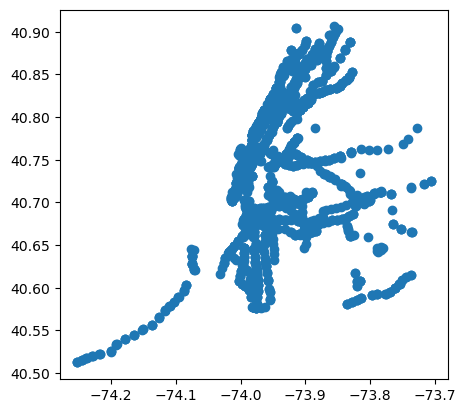

In [21]:
transit_transform_2017_gdf[transit_transform_2017_gdf['cityabbr']=='newyork'].plot()

<Axes: >

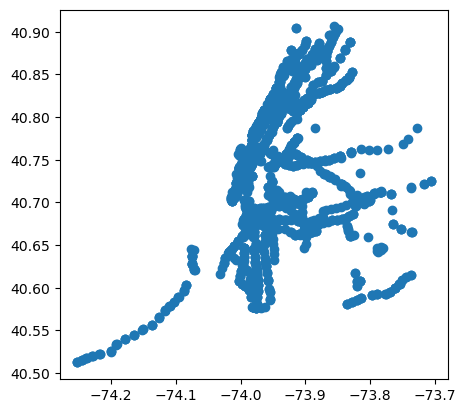

In [22]:
transit_transform_2017_gdf[transit_transform_2017_gdf['cityabbr']=='newyork'].plot()

<Axes: >

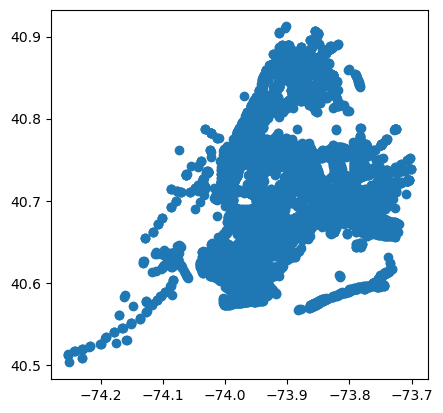

In [23]:
transit_transform_2024_gdf[transit_transform_2024_gdf['cityabbr']=='newyork'].plot()

In [25]:
# check missing city
set(transit_transform_2017['cityabbr'].unique())-set(transit_transform_2024['cityabbr'].unique())

{'copenhagen'}

In [54]:
transit_transform_2024['cityabbr'].nunique()

125

In [32]:
# use DBscan to cluster the stations within each city

sample_city = "london"
sample_stations = transit_transform[transit_transform['cityabbr']==sample_city].reset_index(drop = True)
sample_stations['geometry'] = sample_stations.apply(lambda x: Point(x['lng'], x['lat']), axis = 1)
sample_stations = gpd.GeoDataFrame(sample_stations, geometry = 'geometry')
sample_stations.crs = "EPSG:4326"
# project to local projection
sample_stations = sample_stations.to_crs(epsg = 3857)
sample_stations['x'] = sample_stations['geometry'].apply(lambda x: x.x)
sample_stations['y'] = sample_stations['geometry'].apply(lambda x: x.y)
sample_stations.to_csv(os.path.join(TRANSFORMED_EXPORT,f"{sample_city}_test.csv"), index = False)

In [37]:
for_cluster = sample_stations[sample_stations['public_transport']!='stop_position'].reset_index(drop = True)
dist = 400 # meters
db = DBSCAN(eps = 100, 
            min_samples = 3, 
            ).fit(for_cluster[['x','y']])

In [39]:
for_cluster['cluster'] = db.labels_

<Axes: >

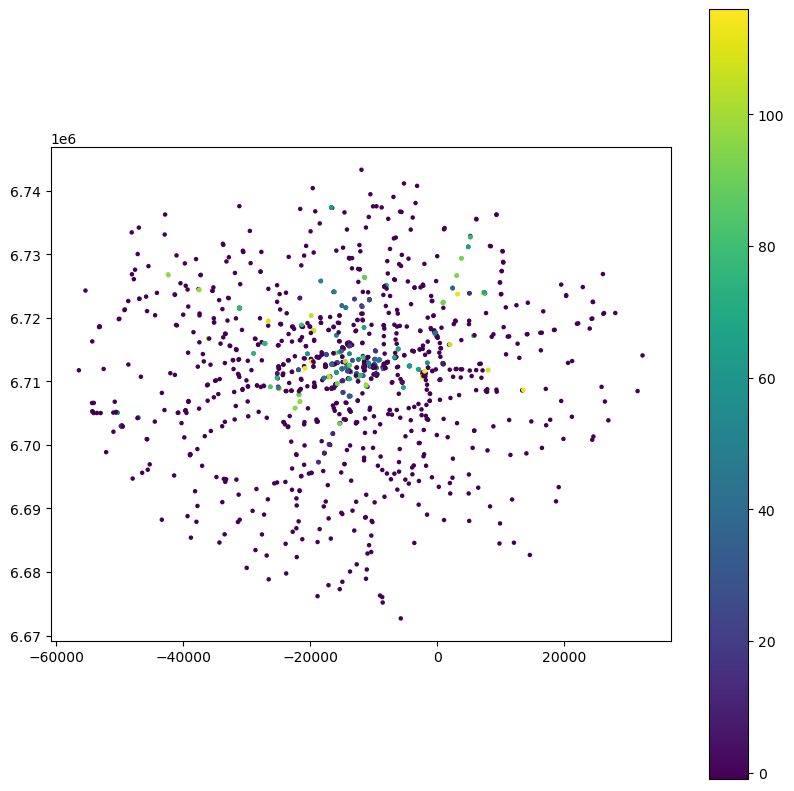

In [40]:
for_cluster.plot(
    column = 'cluster',
    legend = True,
    markersize = 5,
    figsize = (10,10)
)

In [42]:
sample_stations[sample_stations['public_transport']!='stop_position'].groupby('category').size()

category
bus_stop          139
train_station    1239
dtype: int64

In [43]:
# for each train station, created a 800 meter buffer around it. For each bus station, create a 400 meter buffer around it
bus_station = transit_transform[transit_transform['category']=='bus_stop'].reset_index(drop = True)
train_station = transit_transform[transit_transform['category']=='train_station'].reset_index(drop = True)
bus_station['geometry'] = bus_station.apply(lambda x: Point(x['lng'], x['lat']), axis = 1)
train_station['geometry'] = train_station.apply(lambda x: Point(x['lng'], x['lat']), axis = 1)
bus_station = gpd.GeoDataFrame(bus_station, geometry = 'geometry')
train_station = gpd.GeoDataFrame(train_station, geometry = 'geometry')
bus_station.crs = "EPSG:4326"
train_station.crs = "EPSG:4326"
dist_bus = 400
dist_train = 800
bus_station = bus_station.to_crs(epsg = 3857)
train_station = train_station.to_crs(epsg = 3857)
bus_station['geometry'] = bus_station.buffer(dist_bus)
train_station['geometry'] = train_station.buffer(dist_train)
bus_station = bus_station.to_crs(epsg = 4326)
train_station = train_station.to_crs(epsg = 4326)
bus_station.head()

,cityabbr,lat,lng,area,category,amenity,bus,public_transport,railway,geometry
0,mexicocity,19.279391,-99.133100,NaN,bus_stop,None,None,stop_position,stop,"POLYGON ((-99.12951 19.27939, -99.12952 19.279..."
1,mexicocity,19.282647,-99.139635,NaN,bus_stop,None,None,stop_position,stop,"POLYGON ((-99.13604 19.28265, -99.13606 19.282..."
2,mexicocity,19.331457,-99.140573,NaN,bus_stop,None,None,stop_position,stop,"POLYGON ((-99.13698 19.33146, -99.13700 19.331..."
3,mexicocity,19.340560,-99.143385,NaN,bus_stop,None,None,stop_position,stop,"POLYGON ((-99.13979 19.34056, -99.13981 19.340..."
4,mexicocity,19.267823,-99.125511,NaN,bus_stop,None,None,stop_position,stop,"POLYGON ((-99.12192 19.26782, -99.12193 19.267..."


In [50]:
# check the hexagon in or out of the buffer
def check_in_buffer(city):
    cityabbr = city.lower().replace(" ", "")
    temp = pd.read_parquet(os.path.join(CURATE_FOLDER, cityabbr+".parquet"))
    temp_hex = temp[['hex_id','res']].drop_duplicates()
    # get the polygon of the hexagons
    temp_hex['geometry'] = temp_hex['hex_id'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, True)))
    temp_hex = gpd.GeoDataFrame(temp_hex, geometry = 'geometry')
    temp_hex.crs = "EPSG:4326"
    
    
    bus_temp = bus_station[bus_station['cityabbr']==cityabbr].reset_index(drop = True)
    train_temp = train_station[train_station['cityabbr']==cityabbr].reset_index(drop = True)
    bus_temp['bus_400'] = 1
    train_temp['train_800'] = 1
    
    
    temp_hex_bus = gpd.sjoin(temp_hex, bus_temp[['geometry','bus_400']], how = 'left').fillna(0)
    temp_hex_train = gpd.sjoin(temp_hex, train_temp[['geometry','train_800']], how = 'left').fillna(0)
    temp_hex_update = temp_hex[['hex_id', 'res']]\
        .merge(temp_hex_bus[['hex_id','bus_400']], on = 'hex_id', how = 'left')\
        .merge(temp_hex_train[['hex_id','train_800']], on = 'hex_id', how = 'left')
    temp_hex_update = temp_hex_update.groupby(['hex_id','res']).agg({'bus_400':'max','train_800':'max'}).reset_index()
    return temp_hex_update

In [51]:

all_hex = []
for city in tqdm(city_meta['City']):
    try:
        temp = check_in_buffer(city)
        temp['cityabbr'] = city.lower().replace(" ", "")
        all_hex.append(temp)
    except:
        print(city)
all_hex = pd.concat(all_hex).reset_index(drop = True)

 31%|███▏      | 40/127 [01:19<01:47,  1.24s/it]

In [52]:
all_hex.to_parquet(os.path.join(EXPORT_FOLDER, "c_hex_transit_buffer.parquet"), index = False) 
# this file has not consider that there are hexes that are out of the city boundary. Need to filter them out

bus_400
0.0    170828
1.0     79011
dtype: int64

# Add the indicator to show whether the hexid is within the specified city boundary

In [4]:
EXPORTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_pois"
if not os.path.exists(EXPORTFOLDER):
    os.makedirs(EXPORTFOLDER)
city_bound_folder = "/lustre1/g/geog_pyloo/05_timemachine/_raw/r_boundary_osm"
bound_files = os.listdir(city_bound_folder)

In [17]:

def get_city_in_out(city):
    cityabbr = city.lower().replace(" ", "")
    if city in ["Gainesville, FL", "Portland, OR"]:
        bound_sample = cityabbr.split(",")[0]+".geojson"
    geo_sample = gpd.read_file(os.path.join(city_bound_folder, bound_sample))
    # boundary_polygon = geo_sample.to_crs(epsg=4326).geometry[0].convex_hull
    geo_sample['in_city'] = 1

    temp = pd.read_parquet(os.path.join(CURATE_FOLDER, cityabbr+".parquet"))
    temp_hex = temp[['hex_id','res']].drop_duplicates()
    # get the polygon of the hexagons
    temp_hex['geometry'] = temp_hex['hex_id'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, True)))
    temp_hex = gpd.GeoDataFrame(temp_hex, geometry = 'geometry')
    temp_hex.crs = "EPSG:4326"
    temp_hex_join = gpd.sjoin(temp_hex, geo_sample[['in_city','geometry']], how = 'left').fillna(0)
    return temp_hex_join

In [18]:
dfall = []
# dfadd = []
outliers = ["Gainesville, FL", "Portland, OR"]
for city in tqdm(city_meta['City']):
    try:
        temp = get_city_in_out(city)
        temp['cityabbr'] = city.lower().replace(" ", "")
        dfall.append(temp)
    except:
        print(city)
dfall = pd.concat(dfall).reset_index(drop = True)

100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


In [20]:
dfadd = pd.concat(dfadd).reset_index(drop = True)
dfall = pd.concat([dfall, dfadd]).reset_index(drop = True)
dfall['cityabbr'].nunique()

127

In [21]:
dfall.to_parquet(os.path.join(EXPORT_FOLDER, "c_hex_in_city.parquet"), index = False)

# Merge all features for the hexes

In [31]:
# load the transit-buffer
all_hex = pd.read_parquet(os.path.join(EXPORT_FOLDER, "c_hex_transit_buffer.parquet"))
# load the in_city file
dfall = pd.read_parquet(os.path.join(EXPORT_FOLDER, "c_hex_in_city.parquet"))
# load the distance to center file
dist_center = pd.read_parquet(os.path.join(EXPORT_FOLDER, "c_hex_ctr_dist.parquet"))
# make sure each file has 127 cities
print(all_hex['cityabbr'].nunique())
print(dfall['cityabbr'].nunique())
print(dist_center['city'].nunique())
dist_center['cityabbr'] = dist_center['city'].str.lower().str.replace(" ", "")

127
127
127


In [36]:
# merge the three
all_hex = all_hex.merge(dfall[['hex_id','in_city','cityabbr']], on = ['hex_id','cityabbr'], how = 'left')\
    .merge(dist_center[['hex_id','dist_ctr_m','cityabbr']], on = ['hex_id','cityabbr'], how = 'left')
all_hex

,hex_id,res,bus_400,train_800,cityabbr,in_city,dist_ctr_m
0,88c2e30201fffff,8,1.0,1.0,buenosaires,1.0,9126.663212
1,88c2e30203fffff,8,1.0,1.0,buenosaires,1.0,9931.670411
2,88c2e30205fffff,8,1.0,1.0,buenosaires,1.0,8530.320164
3,88c2e30207fffff,8,1.0,1.0,buenosaires,1.0,9342.942345
4,88c2e30209fffff,8,1.0,1.0,buenosaires,1.0,8960.518066
...,...,...,...,...,...,...,...
7661056,8c275936ea4e9ff,12,0.0,1.0,chicago,0.0,22874.788383
7661057,8c275936ead55ff,12,0.0,0.0,chicago,0.0,23272.021143
7661058,8c275936eb21bff,12,0.0,0.0,chicago,0.0,23362.373631
7661059,8c275936ec4b1ff,12,0.0,0.0,chicago,0.0,24446.669533


In [37]:
all_hex.to_parquet(os.path.join(EXPORT_FOLDER, "c_hex_all_spatial.parquet"), index = False)

In [ ]:
# delete the intermediate files
os.remove(os.path.join(EXPORT_FOLDER, "c_hex_transit_buffer.parquet"))
os.remove(os.path.join(EXPORT_FOLDER, "c_hex_in_city.parquet"))
os.remove(os.path.join(EXPORT_FOLDER, "c_hex_ctr_dist.parquet"))